# SENSITIVITY ANALYSIS

## Import Packages

In [40]:
import os
os.getcwd()
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import logging
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import ttest_ind
import calendar
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm, ListedColormap

## Load Data

### FFDI

In [3]:
# FFDI: 2005-2024
ffdi_nc = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI.nc')
ffdi_nc["ffdi"] = ffdi_nc["__xarray_dataarray_variable__"]
ffdi_var = ffdi_nc["ffdi"]  # select the variable as a dataarray

# FFDI: 1979-1998:
ffdi_nc_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI_old.nc')
ffdi_nc_old["ffdi"] = ffdi_nc_old["__xarray_dataarray_variable__"]
ffdi_var_old = ffdi_nc_old["ffdi"]  # select the variable as a DataArray

### Temperature

In [4]:
# temp: 2005-2024
temp_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/temp_new.nc')
temp_new = temp_var_new["tasmax"]

# temp: 1979-1998
temp_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/temp_old.nc')
temp_old = temp_var_old["tasmax"]

### Relative Humidity

In [5]:
# rh: 2005-2024
rh_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/rh_new.nc')
rh_new = rh_var_new["hurs"]

# rh: 1979-1998
rh_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/rh_old.nc')
rh_old = rh_var_old["hurs"]

### Windspeed

In [6]:
# ws: 2005-2024
wind_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/windspeed_new.nc')
wind_var_new["wind"] = wind_var_new["__xarray_dataarray_variable__"]
wind_new = wind_var_new["wind"]

# ws: 1979-1998
wind_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/windspeed_old.nc')
wind_var_old["wind"] = wind_var_old["__xarray_dataarray_variable__"]
wind_old = wind_var_old["wind"]

### DF

In [21]:
# df: 2005-2024
df_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/df_new.nc')
df_var_new["df"] = df_var_new["__xarray_dataarray_variable__"]
df_new = df_var_new["df"]

# df: 1979-1998
df_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/df_old.nc')
df_var_old["df"] = df_var_old["__xarray_dataarray_variable__"]
df_old = df_var_old["df"]

# -----------------------------------------------------------------------

# SENSITIVITY ANALYSIS

In [29]:
# can we attribute these changes in distribution to a particular (or multiple) variables?

In [7]:
rand_nums=(np.random.randint(low=0, high=52, size=(7,7,7305))) # loop o
print(rand_nums)
# if 10, 11

#subset your ffdi data and dates to be only those of high fire danger days
#then, by month, for each month extract 100 (start and then go to 1000 later)

# tricky bc diff grid cells ahve diff number of high fire days. 
# for each grid cell

# randomise each component (for same month. nov with nov), so we dont constrain to 50for the experiments

[[[11 36 26 ... 29  4  7]
  [22  9 11 ...  4 23 36]
  [16 11 51 ... 35  2 15]
  ...
  [33 40  7 ... 41 14  2]
  [ 3  2  0 ... 17 16  8]
  [ 5 21 17 ...  2 44 15]]

 [[39 20  6 ... 22  0 29]
  [12 14 29 ... 15 25 44]
  [17  5 10 ... 24 29 18]
  ...
  [14  3 17 ...  3 12 24]
  [35 44 40 ... 40  5 41]
  [44  4  1 ... 22 33 39]]

 [[42  4 10 ... 33  5 11]
  [38 31 27 ... 19  7 15]
  [49 26 27 ... 32 13 44]
  ...
  [ 9 27 42 ... 36 31 37]
  [29  3 10 ... 21 42  6]
  [ 4 45 34 ... 23 43 23]]

 ...

 [[ 3  1  3 ... 19 29 42]
  [24 20 42 ... 30 22  5]
  [39 33 41 ... 18 48 39]
  ...
  [ 5 24 48 ... 51  9 14]
  [22 24 49 ...  1 29 36]
  [ 0 42 36 ...  0 16 22]]

 [[49 33 14 ... 13 50 36]
  [25 27  1 ... 23 10 32]
  [33 45 11 ... 24  4 32]
  ...
  [25 37 26 ... 39 37 23]
  [34 51 29 ... 32 29 16]
  [15 27 31 ... 21 32 18]]

 [[13 51  5 ... 43 51 33]
  [17 28 10 ... 29 34 16]
  [23 46 26 ... 23 40 21]
  ...
  [ 8 33 17 ... 20 14 11]
  [20 19 15 ... 43  4 24]
  [22 19  1 ... 29 24 46]]]


CONTROL EXPERIMENT: only for 2005-2024
- STEP 1: get the FFDI > 50 dates and assign numbers to them (i.e. 1,2,3,4) for each month
- STEP 2: randomly generate an array of 1000 numbers (with replacement) to select from these days
- ----> or we could do just directly resample masked datasets. maybe make new netcdf with masked data
- STEP 3: do this 4x (one set of resampled numbers for each component)
- STEP 4: now u have recalculated df, rh, temp & wind. recalc FFDI
- STEP 5: apply above stat sig testing

# Control variables: Bootstrapping 2005-2024

### Relative Humidity (RH)

In [8]:
n_samples = 7305
boot_months = []

# loop over each month separately
for m, data_m in rh_new.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # add months so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="rh_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# put all months into one dataarray
boot_ds = xr.concat(boot_months, dim="month")

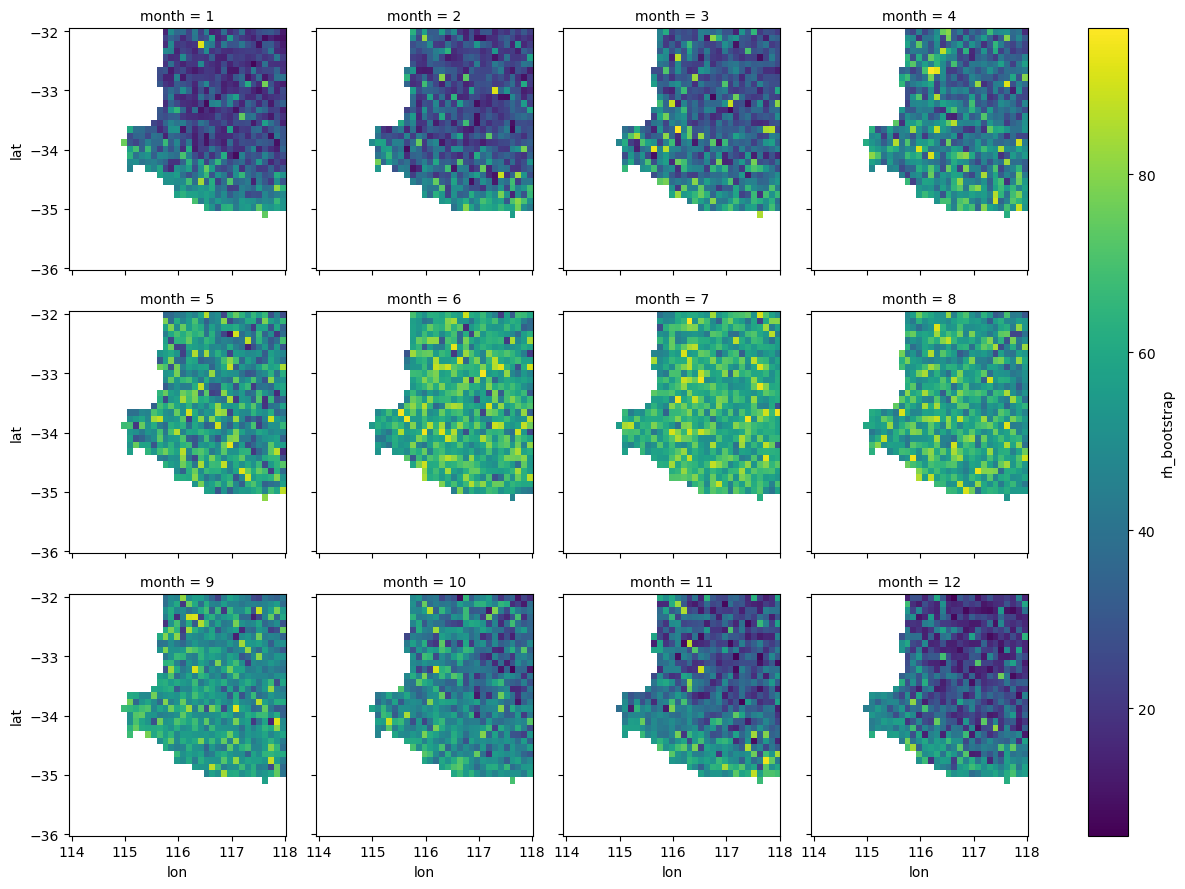

In [9]:
# One random bootstrap draw per month, to test
rand_idx = np.random.randint(0, n_samples)
boot_ds.isel(sample=rand_idx).plot(col="month", col_wrap=4)

In [10]:
#boot_ds.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/rh_new_bootstrapped.nc")

# making a file to store resampled 2005-2024 RH

### Temp bootstrap

In [14]:
# for all months (jan removed)!!
n_samples = 7305 # in actual BARRA dataset, n=7305
boot_months = []

# loop over each month separately
for m, data_m in temp_new.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # Add month dimension so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="temp_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# put all months into one DataArray
boot_ds_temp = xr.concat(boot_months, dim="month")

In [39]:
boot_ds_temp.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/temp_new_bootstrapped.nc")

### Windspeed bootstrap

In [16]:
n_samples = 7305
boot_months = []

# loop over each month separately
for m, data_m in wind_new.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # add month so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="wind_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# combine all months into one array
boot_ds_wind = xr.concat(boot_months, dim="month")

In [41]:
boot_ds_wind.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/wind_new_bootstrapped.nc")

### DF

In [22]:
n_samples = 7305
boot_months = []

for m, data_m in df_new.groupby("time.month"):
    # enforce order: (time, lat, lon), was intially incorrectly arranged
    vals_m = data_m.transpose("time", "lat", "lon").values
    ntime, nlat, nlon = vals_m.shape

    boot_samples = np.full((n_samples, nlat, nlon), np.nan)
    rng = np.random.default_rng()

    for i in range(nlat):      
        for j in range(nlon):  
            cell_vals = vals_m[:, i, j]
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)

    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="df_bootstrap"
    ).expand_dims(month=[m])

    boot_months.append(boot_da)

boot_ds_df = xr.concat(boot_months, dim="month")

In [46]:
boot_ds_df.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/df_new_bootstrapped.nc")

# Loading bootstrapped 2005-2024 samples

In [24]:
temp_new_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/temp_new_bootstrapped.nc')

df_new_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/df_new_bootstrapped.nc')

wind_new_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/wind_new_bootstrapped.nc')

rh_new_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/rh_new_bootstrapped.nc')

# FFDI recalc

In [25]:
temp = temp_new_boot["temp_bootstrap"]
df   = df_new_boot["df_bootstrap"]
rh   = rh_new_boot["rh_bootstrap"]
wind = wind_new_boot["wind_bootstrap"]

temp, df, rh, wind = xr.align(temp, df, rh, wind)

In [26]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind) #* 3.6)   # convert m/s → km/h
)

# ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_new_boot.nc") - use to resave control ffdi

# ------------------------------------------------------------------------

# Bootstrapping FFDI with 1979-1998

### Temperature experiment

In [55]:
n_samples = 7305
boot_months = []

# loop over each month separately
for m, data_m in temp_old.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # add month so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="temp_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# combine all months into one DataArray
boot_ds_temp_old = xr.concat(boot_months, dim="month")

In [56]:
boot_ds_temp_old.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/temp_old_boot.nc") # save as netcdf

In [57]:
temp_old_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/temp_old_boot.nc') # open data

# Recalc FFDI

temp = temp_old_boot["temp_bootstrap"]
df   = df_new_boot["df_bootstrap"]
rh   = rh_new_boot["rh_bootstrap"]
wind = wind_new_boot["wind_bootstrap"]

temp, df, rh, wind = xr.align(temp, df, rh, wind)

In [58]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind) # * 3.6)   # convert m/s → km/h
)

ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_temp_boot.nc") # save output

### RH experiment

In [60]:
n_samples = 7305
boot_months = []

# Loop over each month separately
for m, data_m in rh_old.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # Add month dimension so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="rh_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# Concatenate all months into one DataArray
boot_ds_rh_old = xr.concat(boot_months, dim="month")


In [61]:
boot_ds_rh_old.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/rh_old_boot.nc")
rh_old_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/rh_old_boot.nc')

# Recalc FFDI

temp = temp_new_boot["temp_bootstrap"]
df   = df_new_boot["df_bootstrap"]
rh   = rh_old_boot["rh_bootstrap"]
wind = wind_new_boot["wind_bootstrap"]

temp, df, rh, wind = xr.align(temp, df, rh, wind)

In [62]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind) # * 3.6)   # convert m/s → km/h
)

ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_rh_boot.nc")

### Windspeed experiment

In [63]:
n_samples = 7305
boot_months = []

# Loop over each month separately
for m, data_m in wind_old.groupby("time.month"):
    vals_m = data_m.values  # (time, lat, lon)
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # Add month dimension so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="wind_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# Concatenate all months into one DataArray
boot_ds_wind_old = xr.concat(boot_months, dim="month")


In [64]:
boot_ds_wind_old.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/wind_old_boot.nc")
wind_old_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/wind_old_boot.nc')

# Recalc FFDI

temp = temp_new_boot["temp_bootstrap"]
df   = df_new_boot["df_bootstrap"]
rh   = rh_new_boot["rh_bootstrap"]
wind = wind_old_boot["wind_bootstrap"]

temp, df, rh, wind = xr.align(temp, df, rh, wind)

In [65]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind) # * 3.6)   # convert m/s → km/h
)

ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_wind_boot.nc")

### DF experiment

In [67]:
n_samples = 7305
boot_months = []

# Loop over each month separately
for m, data_m in df_old.groupby("time.month"):
    #vals_m = data_m.values  # (time, lat, lon) SAME 620 ISSUE
    vals_m = data_m.transpose("time", "lat", "lon").values
    boot_samples = np.full((n_samples, vals_m.shape[1], vals_m.shape[2]), np.nan)
    rng = np.random.default_rng()
    
    for i in range(vals_m.shape[1]):      # lat
        for j in range(vals_m.shape[2]):  # lon
            cell_vals = vals_m[:, i, j]         # values only for this month at this cell
            valid = cell_vals[~np.isnan(cell_vals)]
            if valid.size > 0:
                boot_samples[:, i, j] = rng.choice(valid, size=n_samples, replace=True)
    
    # Add month dimension so we can stack later
    boot_da = xr.DataArray(
        boot_samples,
        dims=("sample", "lat", "lon"),
        coords={
            "sample": np.arange(n_samples),
            "lat": data_m.lat,
            "lon": data_m.lon,
        },
        name="df_bootstrap"
    ).expand_dims(month=[m])
    
    boot_months.append(boot_da)

# combine all months into one DataArray
boot_ds_df_old = xr.concat(boot_months, dim="month")

In [68]:
boot_ds_df_old.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/df_old_boot.nc")
df_old_boot = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/df_old_boot.nc')

# Recalc FFDI

temp = temp_new_boot["temp_bootstrap"]
df   = df_old_boot["df_bootstrap"]
rh   = rh_new_boot["rh_bootstrap"]
wind = wind_new_boot["wind_bootstrap"]

temp, df, rh, wind = xr.align(temp, df, rh, wind)

In [69]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind) # * 3.6)   # convert m/s → km/h
)

ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_df_boot.nc")

# -------------------------------------------------------------------

# After Pre-processing - everything above this = only do once

### LOAD DATA

In [28]:
# calling them again so they have diff names

ffdi_temp_ds = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_temp_boot.nc')
ffdi_rh_ds = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_rh_boot.nc')
ffdi_wind_ds = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_wind_boot.nc')
ffdi_df_ds = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_df_boot.nc')
ffdi_control_ds = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/SENSITIVITY/ffdi_new_boot.nc')

In [29]:
# making mean plots across samples 
ffdi_temp = ffdi_temp_ds["__xarray_dataarray_variable__"]
ffdi_rh = ffdi_rh_ds["__xarray_dataarray_variable__"]
ffdi_control = ffdi_control_ds["__xarray_dataarray_variable__"]
ffdi_wind = ffdi_wind_ds["__xarray_dataarray_variable__"]
ffdi_df = ffdi_df_ds["__xarray_dataarray_variable__"]

In [36]:
# Define Mann Whitney U test

def mw_func(a, b):
    """Return p-value of Mann–Whitney U test, ignoring NaNs."""
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if len(a) == 0 or len(b) == 0:
        return np.nan
    return mannwhitneyu(a, b, alternative="two-sided").pvalue

# define 2-proportion z test
def prop_test(a, b):
    # drop NaNs
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if (len(a) == 0) or (len(b) == 0):
        return np.nan
    
    # counts of exceedances
    count = [np.sum(a == 1), np.sum(b == 1)]
    nobs = [len(a), len(b)]
    
    # if both have zero exceedances, skip
    if count[0] == 0 and count[1] == 0:
        return np.nan
    
    stat, p = proportions_ztest(count, nobs)
    return p

## Temp experiment

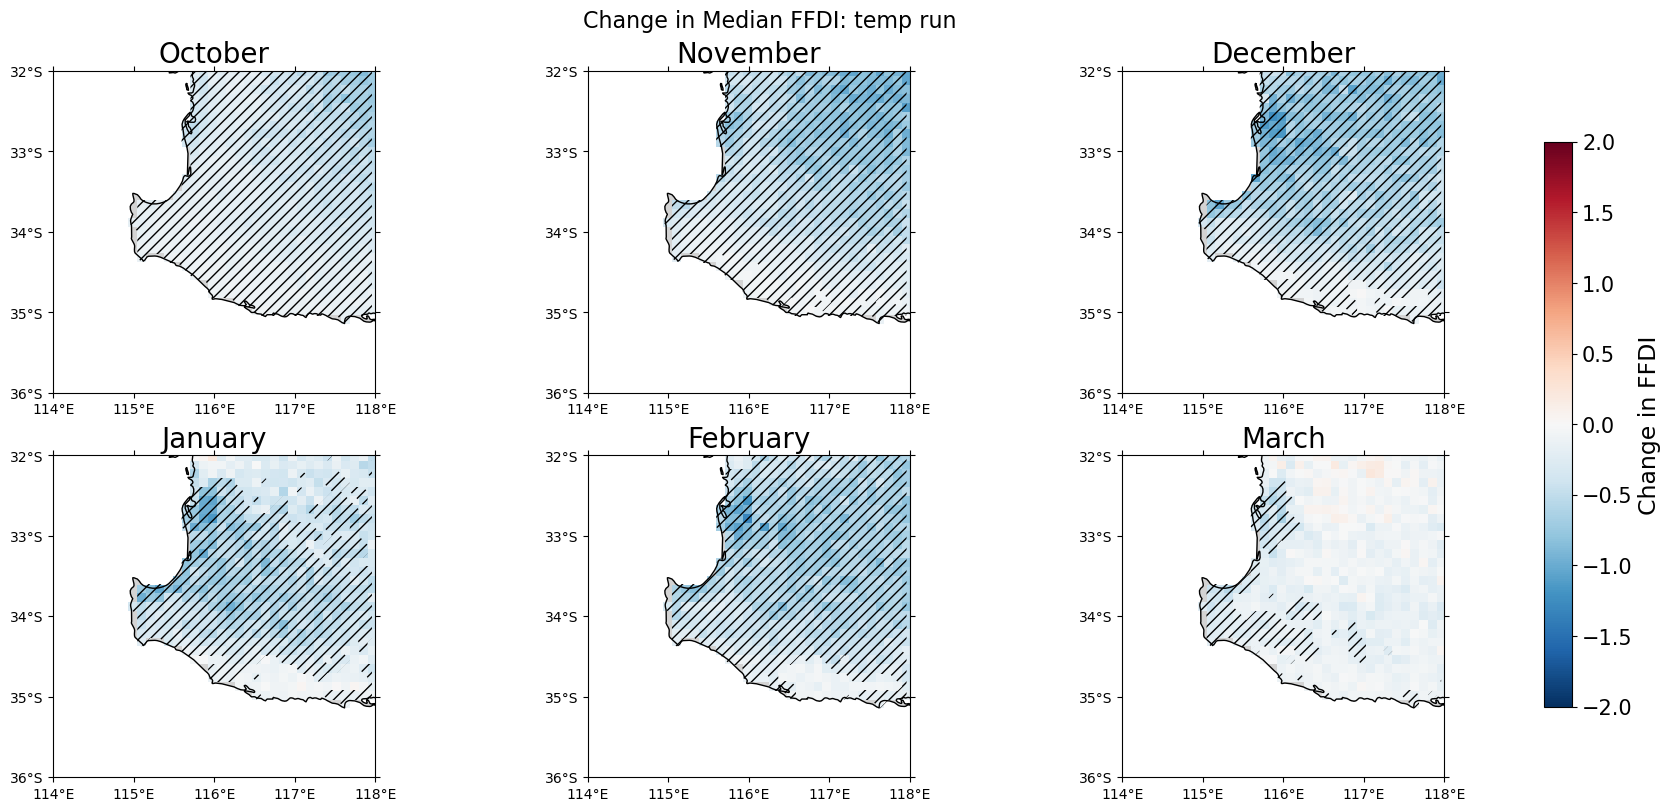

In [35]:
# oct-march
months = [10, 11, 12, 1, 2, 3]

# set-up figure
fig, axes = plt.subplots(
    2, 3, figsize=(18, 8),  # 6 months = 2x3 grid
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# loop over oct-march
for i, m in enumerate(months):
    ax = axes[i]

    # adjust for 0-based indexing
    month_idx = m - 1 if m > 0 else 11  # ensures Dec=11, Jan=0, etc.

    # diff in median
    diff = ffdi_temp.isel(month=month_idx).median(dim="sample") - ffdi_control.isel(month=month_idx).median(dim="sample") 

    # apply MW u test
    pvals = xr.apply_ufunc(
        mw_func, # calls previously created function
        ffdi_control.isel(month=month_idx),
        ffdi_temp.isel(month=month_idx),
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot difference
    im = diff.plot(
        ax=ax,
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-2, vmax=2
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")

    # add lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for stat sig grid cells
    sig = (pvals < 0.05)
    ax.contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    ax.set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20) # month title

# colourbar formatting
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.8
)
cbar.set_label("Change in FFDI", fontsize=17)
cbar.ax.tick_params(labelsize=15)

plt.suptitle("Change in Median FFDI: temp run", fontsize=16)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/median_temp_run.png", dpi=600)
plt.show()

/jobfs/153166189.gadi-pbs/ipykernel_3585159/1122856547.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


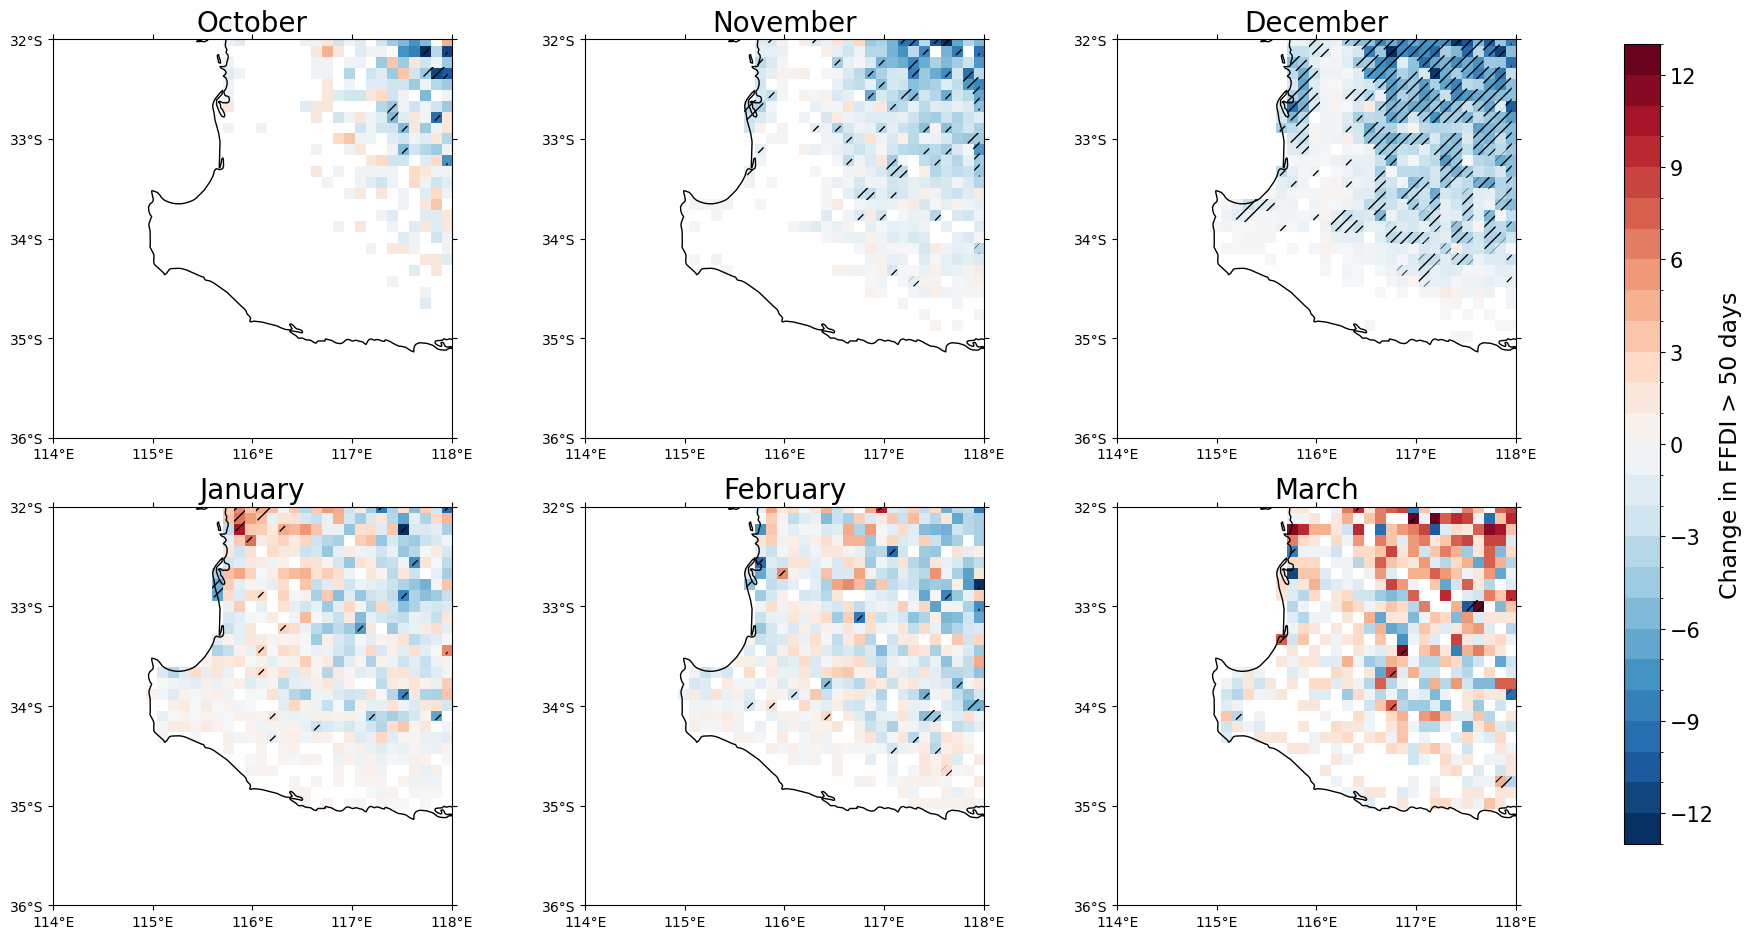

In [55]:
# --- Proportions test: two-proportion z-test ---
def prop_test(a, b):
    # drop NaNs
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if (len(a) == 0) or (len(b) == 0):
        return np.nan
    
    # counts of exceedances
    count = [np.sum(a == 1), np.sum(b == 1)]
    nobs = [len(a), len(b)]
    
    # if both have zero exceedances, skip
    if count[0] == 0 and count[1] == 0:
        return np.nan
    
    stat, p = proportions_ztest(count, nobs)
    return p

# Only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select the month directly by coordinate
    ffdi_m1 = ffdi_temp.sel(month=m)  # shape: (sample=7305, lat, lon)
    ffdi_m2 = ffdi_control.sel(month=m)      # shape: (sample=7305, lat, lon)

    # mask FFDI > 50
    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    # calculate proportion of exceedances per grid cell
    freq1 = ffdi_m1_50.sum(dim="sample")  # fraction of samples > 50
    freq2 = ffdi_m2_50.sum(dim="sample")  # fraction of samples > 50

    # difference in proportion (new - old)
    diff = freq1 - freq2

    # --- p-values using two-proportion z-test ---
    pvals = xr.apply_ufunc(
        prop_test,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # Define discrete bins (example: integer differences from -max to +max)
    max_diff = int(np.nanmax(np.abs(diff)))  # largest absolute change in frequency
    levels = np.arange(-max_diff, max_diff+1, 1)  # e.g., step=1 day
    # Create a norm for discrete colors
    norm = BoundaryNorm(levels, ncolors=plt.cm.RdBu_r.N, clip=True)
    
    # plot difference map
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap=plt.cm.RdBu_r,
        norm=norm,
        add_colorbar=False
    )
    im.cmap.set_bad("white")  # make zeros (masked) white
    diff_masked = diff.where(diff != 0)  # mask zeros
    im = diff_masked.plot(ax=axes[i], x='lon', y='lat', cmap=plt.cm.RdBu_r, norm=norm, add_colorbar=False)
    im.cmap.set_bad("white")


    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Set extent for SWWA (adjust as needed)
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree())
  
    # Add ticks only (no axis labels)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Explicitly include both edges in ticks
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree())
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())

    # Formatters
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)

    # Draw ticks on all four sides
    axes[i].tick_params(
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # Stippling for significant cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize=20)


cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in FFDI > 50 days")


#plt.suptitle("Change in FFDI > 50 frequency: temp run", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/exterme_temp_run.png", dpi=600)
plt.show()

# RH

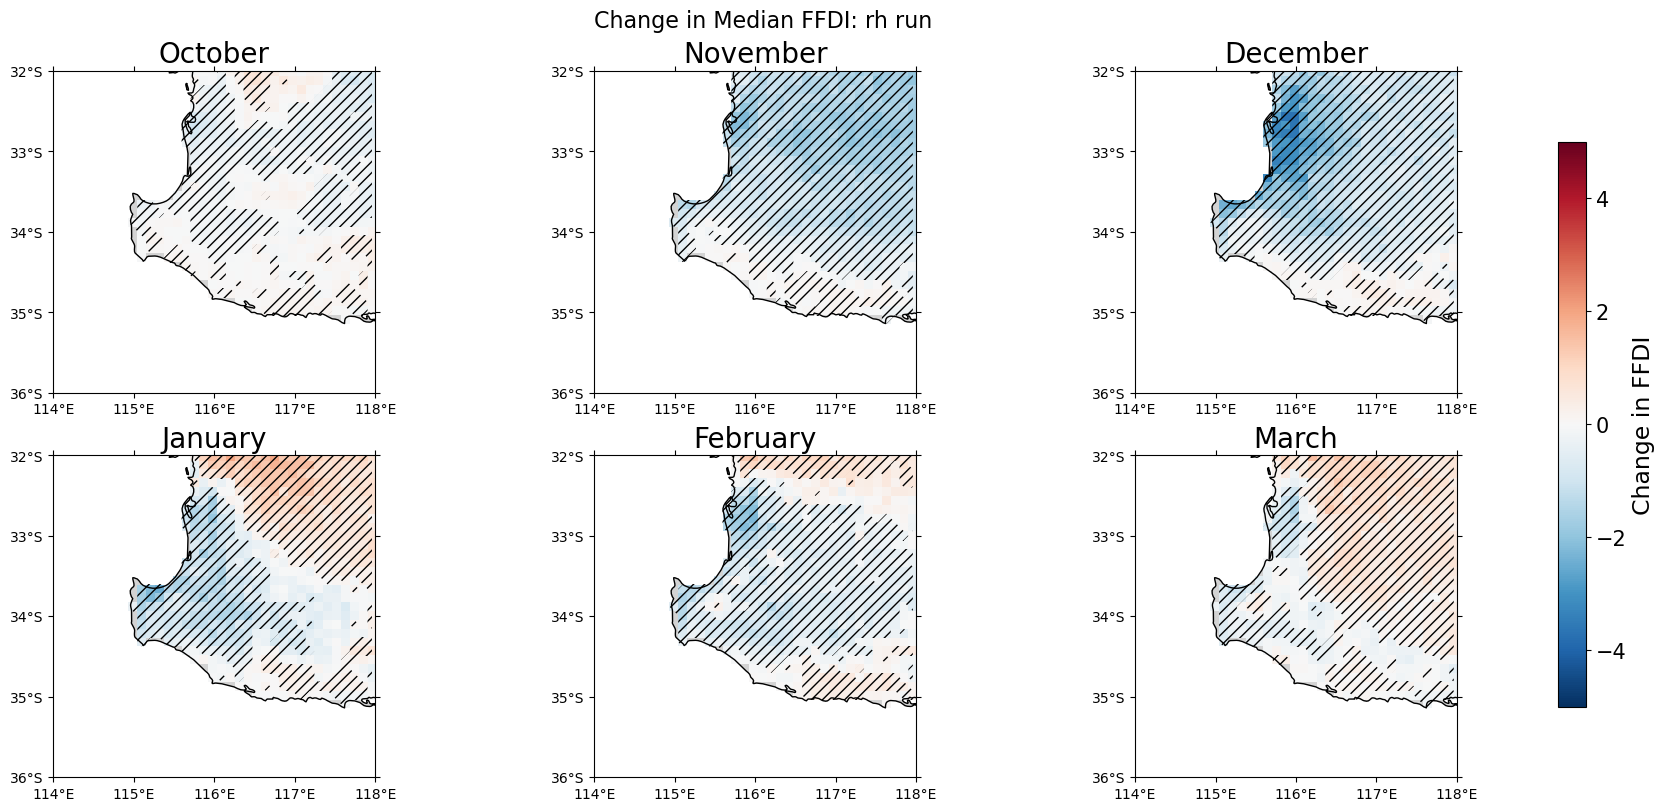

In [45]:
# oct-march
months = [10, 11, 12, 1, 2, 3]

# set-up figure
fig, axes = plt.subplots(
    2, 3, figsize=(18, 8),  # 6 months = 2x3 grid
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# loop over oct-march
for i, m in enumerate(months):
    ax = axes[i]

    # adjust for 0-based indexing
    month_idx = m - 1 if m > 0 else 11  # ensures Dec=11, Jan=0, etc.

    # diff in median
    diff = ffdi_rh.isel(month=month_idx).median(dim="sample") - ffdi_control.isel(month=month_idx).median(dim="sample") 

    # apply MW u test
    pvals = xr.apply_ufunc(
        mw_func, # calls previously created function
        ffdi_control.isel(month=month_idx),
        ffdi_rh.isel(month=month_idx),
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot difference
    im = diff.plot(
        ax=ax,
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-5, vmax=5
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")

    # add lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for stat sig grid cells
    sig = (pvals < 0.05)
    ax.contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    ax.set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20) # month title

# colourbar formatting
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.8
)
cbar.set_label("Change in FFDI", fontsize=17)
cbar.ax.tick_params(labelsize=15)

plt.suptitle("Change in Median FFDI: rh run", fontsize=16)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/median_rh_run.png", dpi=600)
plt.show()

/jobfs/153166189.gadi-pbs/ipykernel_3585159/2611643733.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


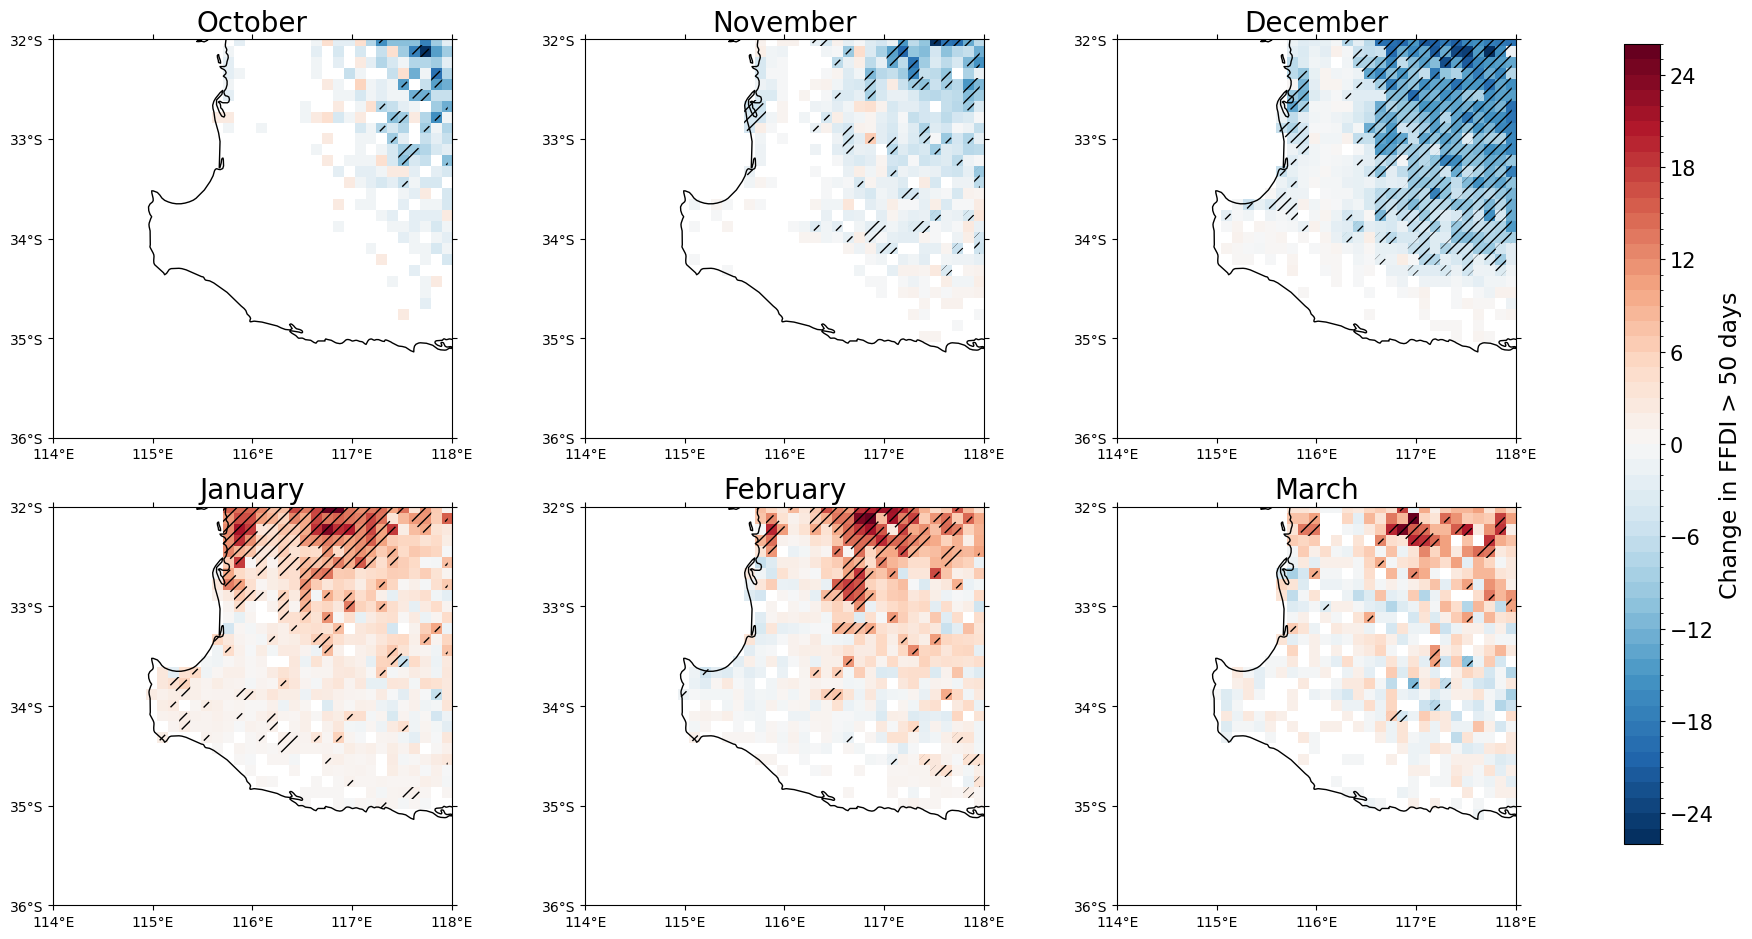

In [54]:
# Only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select the month directly by coordinate
    ffdi_m1 = ffdi_rh.sel(month=m)  # shape: (sample=7305, lat, lon)
    ffdi_m2 = ffdi_control.sel(month=m)      # shape: (sample=7305, lat, lon)

    # mask FFDI > 50
    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    # calculate proportion of exceedances per grid cell
    freq1 = ffdi_m1_50.sum(dim="sample")  # fraction of samples > 50
    freq2 = ffdi_m2_50.sum(dim="sample")  # fraction of samples > 50

    # difference in proportion (new - old)
    diff = freq1 - freq2

    # --- p-values using two-proportion z-test ---
    pvals = xr.apply_ufunc(
        prop_test,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # Define discrete bins (example: integer differences from -max to +max)
    max_diff = int(np.nanmax(np.abs(diff)))  # largest absolute change in frequency
    levels = np.arange(-max_diff, max_diff+1, 1)  # e.g., step=1 day
    # Create a norm for discrete colors
    norm = BoundaryNorm(levels, ncolors=plt.cm.RdBu_r.N, clip=True)
    
    # plot difference map
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap=plt.cm.RdBu_r,
        norm=norm,
        add_colorbar=False
    )
    im.cmap.set_bad("white")  # make zeros (masked) white
    diff_masked = diff.where(diff != 0)  # mask zeros
    im = diff_masked.plot(ax=axes[i], x='lon', y='lat', cmap=plt.cm.RdBu_r, norm=norm, add_colorbar=False)
    im.cmap.set_bad("white")


    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Set extent for SWWA (adjust as needed)
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree())
  
    # Add ticks only (no axis labels)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Explicitly include both edges in ticks
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree())
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())

    # Formatters
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)

    # Draw ticks on all four sides
    axes[i].tick_params(
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # Stippling for significant cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize=20)


cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in FFDI > 50 days")


#plt.suptitle("Change in FFDI > 50 frequency: rh run", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/extreme_rh_run.png", dpi=600)
plt.show()

# Windspeed

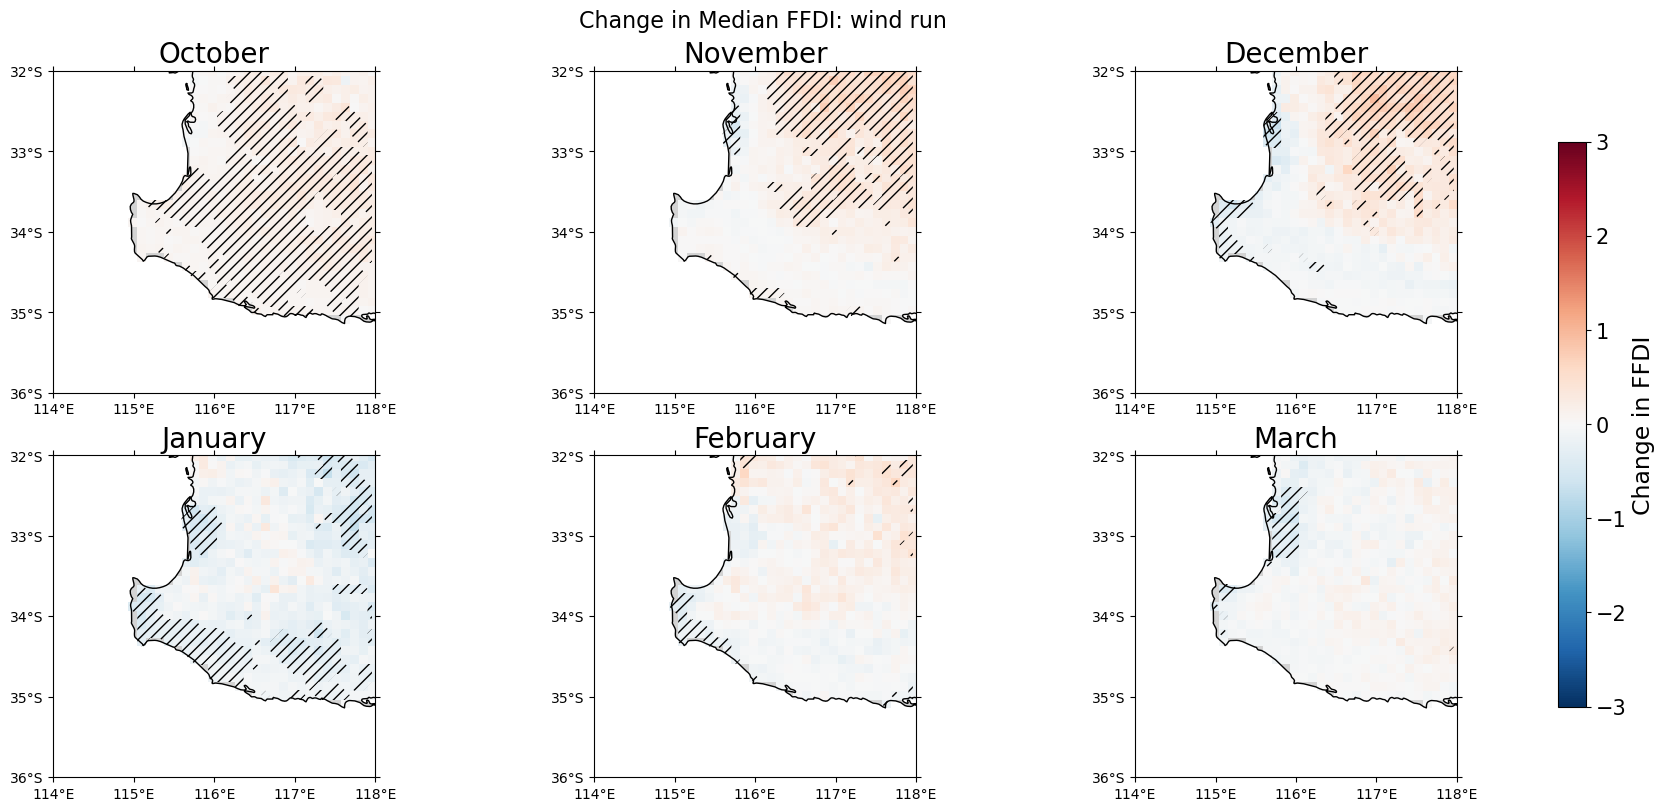

In [65]:
# oct-march
months = [10, 11, 12, 1, 2, 3]

# set-up figure
fig, axes = plt.subplots(
    2, 3, figsize=(18, 8),  # 6 months = 2x3 grid
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# loop over oct-march
for i, m in enumerate(months):
    ax = axes[i]

    # adjust for 0-based indexing
    month_idx = m - 1 if m > 0 else 11  # ensures Dec=11, Jan=0, etc.

    # diff in median
    diff = ffdi_wind.isel(month=month_idx).median(dim="sample") - ffdi_control.isel(month=month_idx).median(dim="sample") 

    # apply MW u test
    pvals = xr.apply_ufunc(
        mw_func, # calls previously created function
        ffdi_control.isel(month=month_idx),
        ffdi_wind.isel(month=month_idx),
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot difference
    im = diff.plot(
        ax=ax,
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-3, vmax=3
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")

    # add lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for stat sig grid cells
    sig = (pvals < 0.05)
    ax.contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    ax.set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20) # month title

# colourbar formatting
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.8
)
cbar.set_label("Change in FFDI", fontsize=17)
cbar.ax.tick_params(labelsize=15)

plt.suptitle("Change in Median FFDI: wind run", fontsize=16)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/median_wind_run.png", dpi=600)
plt.show()

/jobfs/153166189.gadi-pbs/ipykernel_3585159/894478316.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


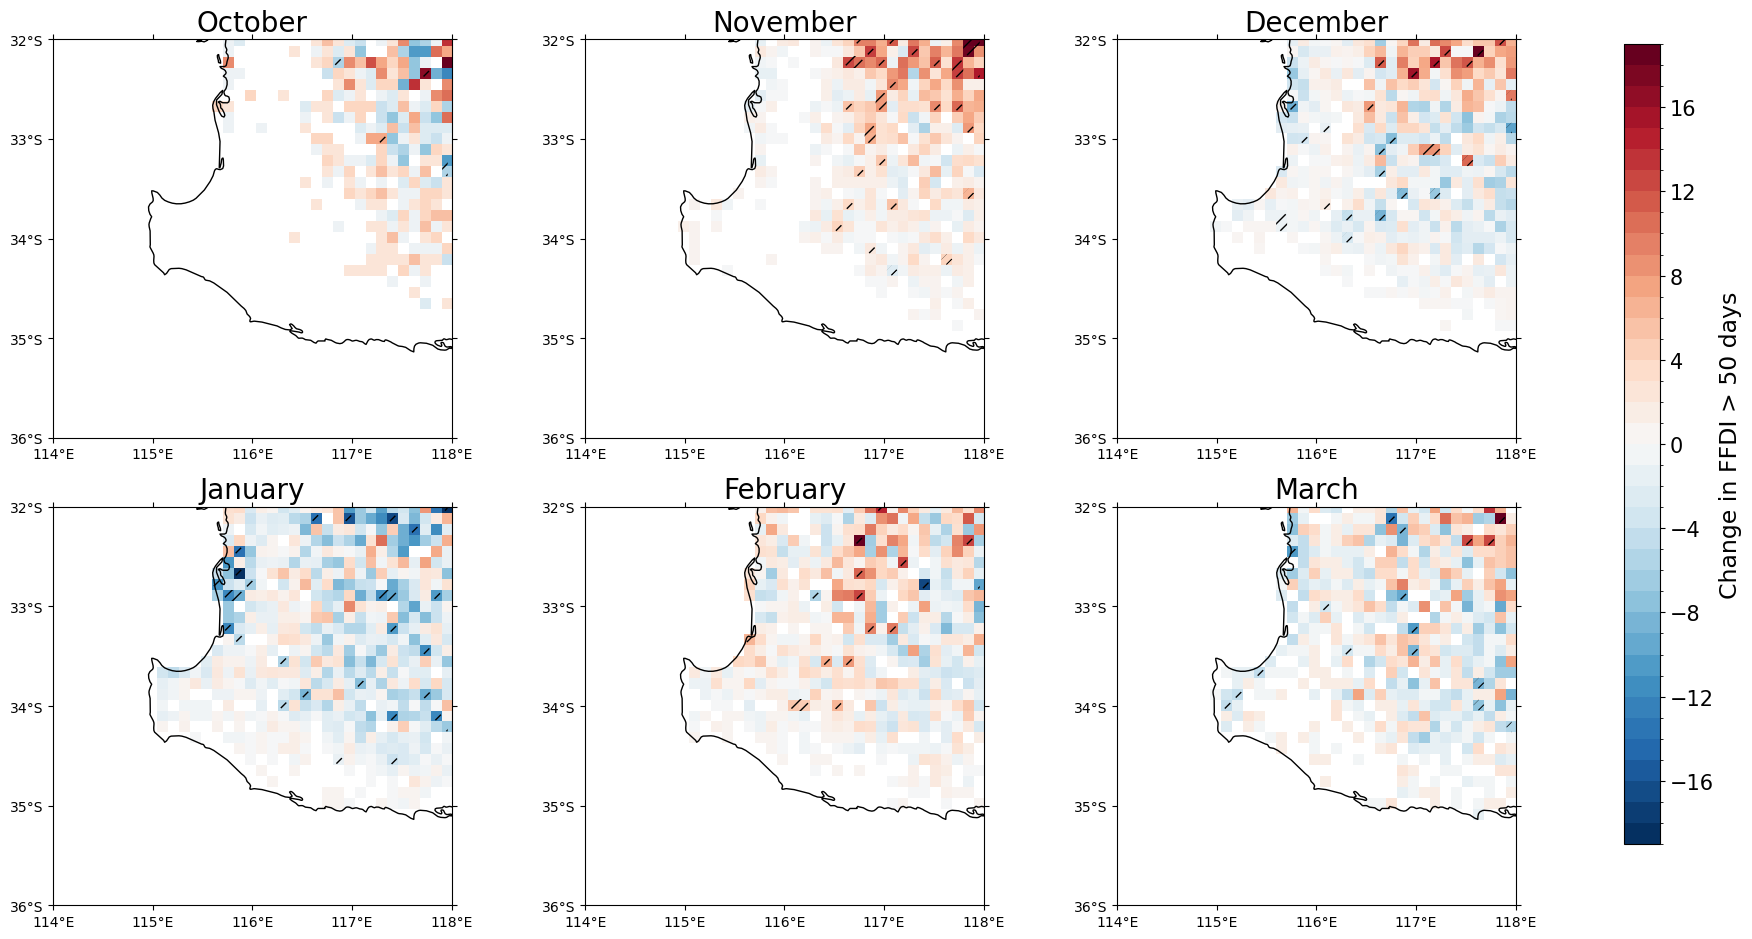

In [68]:
# Only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select the month directly by coordinate
    ffdi_m1 = ffdi_wind.sel(month=m)  # shape: (sample=7305, lat, lon)
    ffdi_m2 = ffdi_control.sel(month=m)      # shape: (sample=7305, lat, lon)

    # mask FFDI > 50
    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    # calculate proportion of exceedances per grid cell
    freq1 = ffdi_m1_50.sum(dim="sample")  # fraction of samples > 50
    freq2 = ffdi_m2_50.sum(dim="sample")  # fraction of samples > 50

    # difference in proportion (new - old)
    diff = freq1 - freq2

    # --- p-values using two-proportion z-test ---
    pvals = xr.apply_ufunc(
        prop_test,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # Define discrete bins (example: integer differences from -max to +max)
    max_diff = int(np.nanmax(np.abs(diff)))  # largest absolute change in frequency
    levels = np.arange(-max_diff, max_diff+1, 1)  # e.g., step=1 day
    # Create a norm for discrete colors
    norm = BoundaryNorm(levels, ncolors=plt.cm.RdBu_r.N, clip=True)
    
    # plot difference map
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap=plt.cm.RdBu_r,
        norm=norm,
        add_colorbar=False
    )
    im.cmap.set_bad("white")  # make zeros (masked) white
    diff_masked = diff.where(diff != 0)  # mask zeros
    im = diff_masked.plot(ax=axes[i], x='lon', y='lat', cmap=plt.cm.RdBu_r, norm=norm, add_colorbar=False)
    im.cmap.set_bad("white")


    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Set extent for SWWA (adjust as needed)
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree())
  
    # Add ticks only (no axis labels)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Explicitly include both edges in ticks
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree())
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())

    # Formatters
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)

    # Draw ticks on all four sides
    axes[i].tick_params(
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # Stippling for significant cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize=20)


cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in FFDI > 50 days")


plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/extreme_wind_run.png", dpi=600)
plt.show()

# DF

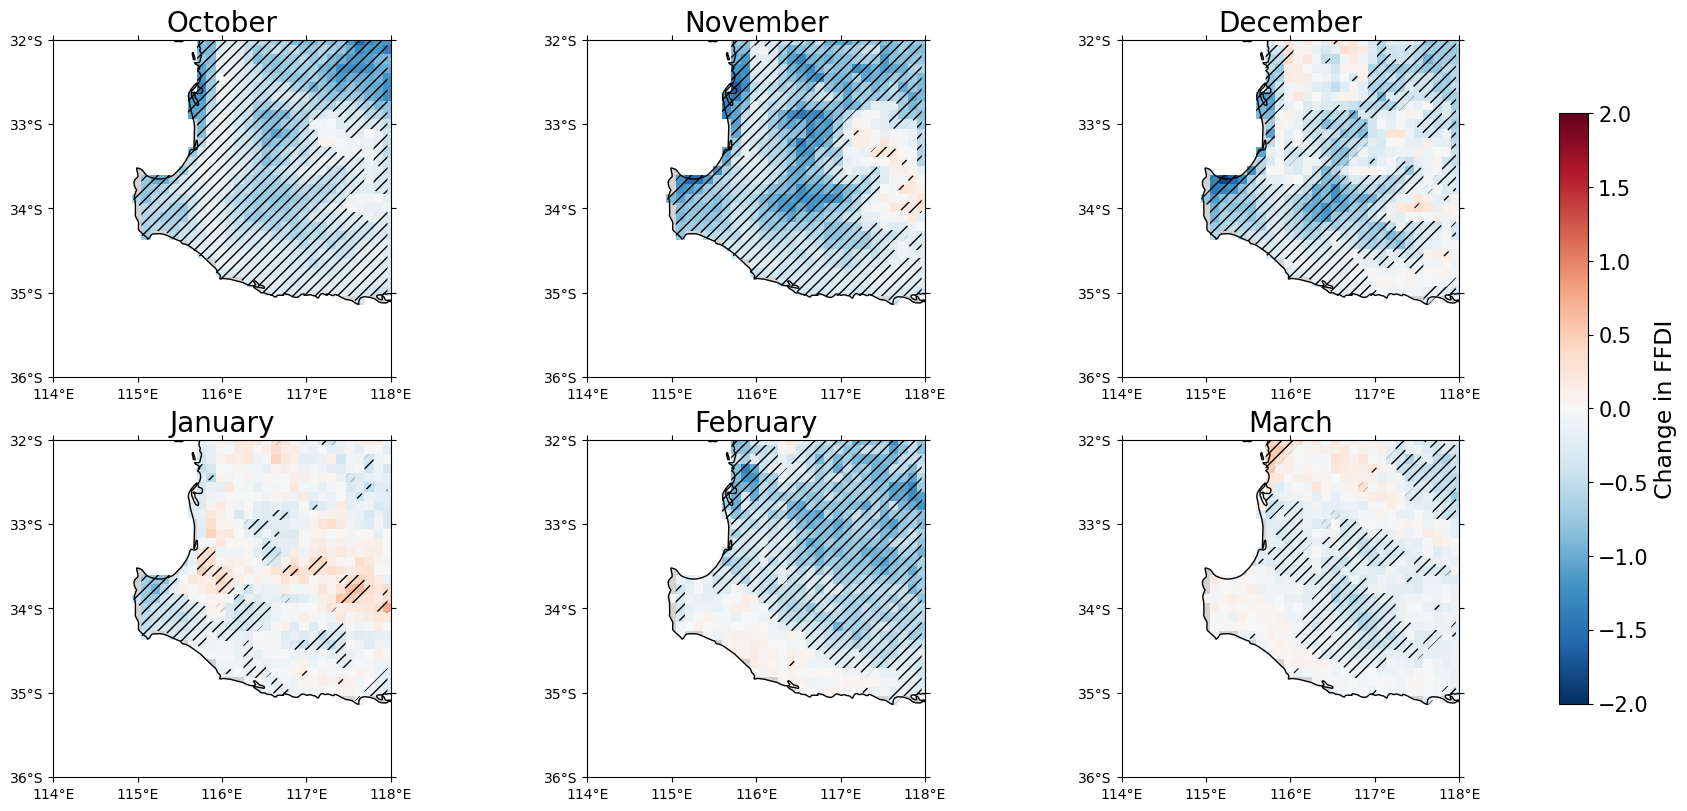

In [58]:
# oct-march
months = [10, 11, 12, 1, 2, 3]

# set-up figure
fig, axes = plt.subplots(
    2, 3, figsize=(18, 8),  # 6 months = 2x3 grid
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# loop over oct-march
for i, m in enumerate(months):
    ax = axes[i]

    # adjust for 0-based indexing
    month_idx = m - 1 if m > 0 else 11  # ensures Dec=11, Jan=0, etc.

    # diff in median
    diff = ffdi_df.isel(month=month_idx).median(dim="sample") - ffdi_control.isel(month=month_idx).median(dim="sample") 

    # apply MW u test
    pvals = xr.apply_ufunc(
        mw_func, # calls previously created function
        ffdi_control.isel(month=month_idx),
        ffdi_df.isel(month=month_idx),
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot difference
    im = diff.plot(
        ax=ax,
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-2, vmax=2
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")

    # add lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for stat sig grid cells
    sig = (pvals < 0.05)
    ax.contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    ax.set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20) # month title

# colourbar formatting
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.8
)
cbar.set_label("Change in FFDI", fontsize=17)
cbar.ax.tick_params(labelsize=15)

#plt.suptitle("Change in Median FFDI: df run", fontsize=16)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/median_df_run.png", dpi=600)
plt.show()

/jobfs/153166189.gadi-pbs/ipykernel_3585159/658883717.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


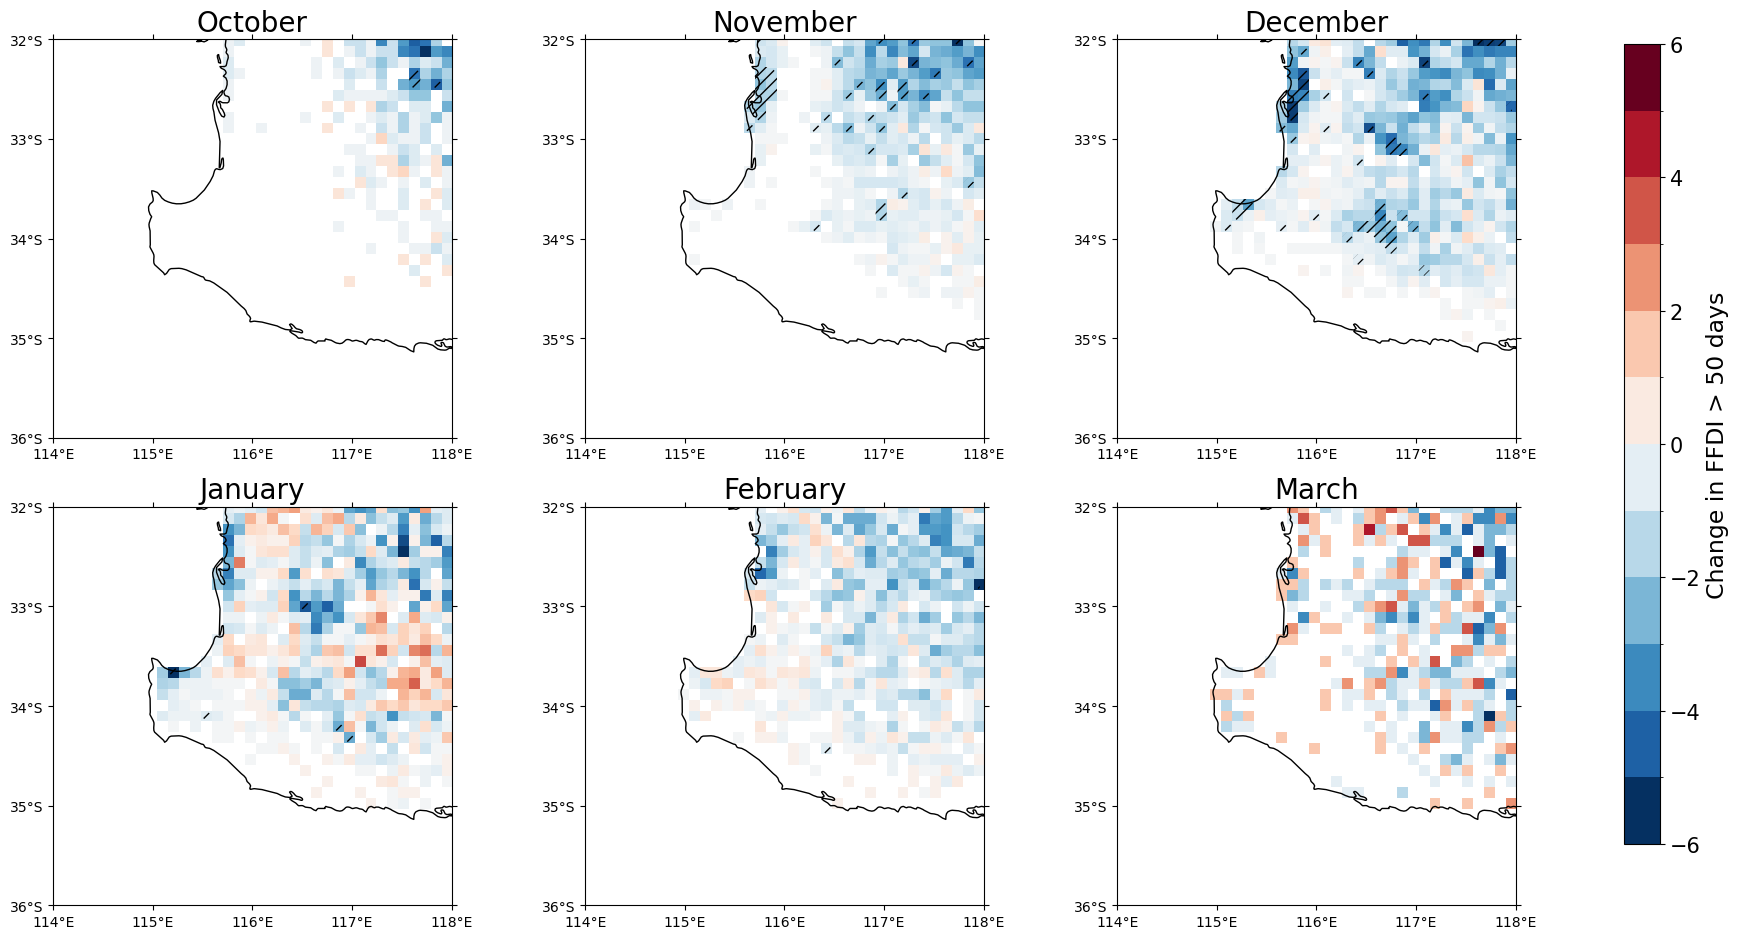

In [62]:
# Only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select the month directly by coordinate
    ffdi_m1 = ffdi_df.sel(month=m)  # shape: (sample=7305, lat, lon)
    ffdi_m2 = ffdi_control.sel(month=m)      # shape: (sample=7305, lat, lon)

    # mask FFDI > 50
    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    # calculate proportion of exceedances per grid cell
    freq1 = ffdi_m1_50.sum(dim="sample")  # fraction of samples > 50
    freq2 = ffdi_m2_50.sum(dim="sample")  # fraction of samples > 50

    # difference in proportion (new - old)
    diff = freq1 - freq2

    # --- p-values using two-proportion z-test ---
    pvals = xr.apply_ufunc(
        prop_test,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["sample"], ["sample"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # Define discrete bins (example: integer differences from -max to +max)
    max_diff = int(np.nanmax(np.abs(diff)))  # largest absolute change in frequency
    levels = np.arange(-max_diff, max_diff+1, 1)  # e.g., step=1 day
    # Create a norm for discrete colors
    norm = BoundaryNorm(levels, ncolors=plt.cm.RdBu_r.N, clip=True)
    
    # plot difference map
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap=plt.cm.RdBu_r,
        norm=norm,
        add_colorbar=False
    )
    im.cmap.set_bad("white")  # make zeros (masked) white
    diff_masked = diff.where(diff != 0)  # mask zeros
    im = diff_masked.plot(ax=axes[i], x='lon', y='lat', cmap=plt.cm.RdBu_r, norm=norm, add_colorbar=False)
    im.cmap.set_bad("white")


    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Set extent for SWWA (adjust as needed)
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree())
  
    # Add ticks only (no axis labels)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Explicitly include both edges in ticks
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree())
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())

    # Formatters
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)

    # Draw ticks on all four sides
    axes[i].tick_params(
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # Stippling for significant cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize=20)


cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in FFDI > 50 days")


#plt.suptitle("Change in FFDI > 50 frequency: df run", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/extreme_df_run.png", dpi=600)
plt.show()